<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='65%'></img>

<br>

# Workflow - Siberian Wildfires -  August 2021

Smoke from wildfires in parts of Siberia have set undesirable new records, with experts recording plumes reaching the geographic North Pole for the first time in recorded history and that those in the Sakha region have set unprecedented records for size and intensity.

The forest fires, which occurred in the Siberian regions Sakha, Dzhigda and Okhotsk, have set new records for the period 1 June to 1 August. By mid-August, fires have burned more than 150,000 square kilometres of forest and tundra in Siberia - an area larger than the Netherlands, Belgium, and Denmark combined.

The long-term data are showing worrying trends, with average fire seasons in Siberia and many other parts of the world increasing in intensity and duration. With an increase of the average annual temperature in Siberia, fires in the region starting, on average, earlier and further north than they used to.



Satellites are crucial to monitor wildfires and their impact in the atmosphere and on land. This is even more important in regions where control and monitoring from ground is particularly difficult.<br>
The dynamics and extent of the fires were monitored by different sensors and data. This notebook covers the fires on 12 August 2021 with the following data products:
<a id="top"></a>
- [Copernicus Sentinel-3 OLCI - Level-1B - RGB composite](#sentinel3)
- [AC SAF Metop-ABC GOME-2 - Level 3 - Absorbing Aerosol Index (AAI)](#aai)

<br>

<img src='./img/20210812_siberian_firest_combined.png' alt='' align='centre' width='90%'></img>

<br>

More information in the EUMESAT Science Blog from 17 August 2021: 
> [Smoke from wildfires in parts of Siberia have set undesirable new records](https://www.eumetsat.int/science-blog/siberian-smoke-plume-reaches-north-pole-fires-set-other-unwanted-records)

<hr>

#### Load required libraries

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
from skimage import exposure

from netCDF4 import Dataset
import pandas as pd

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Helper functions

In [3]:
%run ./functions.ipynb

<hr>

## <a id='load_browse_s3'></a>Sentinel-3 OLCI Level-1B data

Images taken by the EUMETSAT-operated Copernicus Sentinel-3 satellite mission show brown-coloured smoke from the fires sprawling across Siberia and up towards the North Pole, where researchers have confirmed that the smoke plume from the fires reached the geographic North Pole, the first time this has been recorded since comprehensive records began in 2003.

<img src='../img/20210812_s3_olci.png' alt='False-Color composite of Sentinel-3 OLCI Level-1B - 12 August 2021' align='centre' width='50%'></img>

<br>

Subsequently, you will learn how to handle and process Sentinel-3 Level-1 data to create a True-Color and False-Color composite respectively.


Sentinel-3 Level-1 data are dissiminated as `.zip archives` when downloaded. The unzipped folder contains 30 data files in `NetCDF` format. Data for each channel is stored in a single `NetCDF` file. Additionally, you get information on `qualityFlags`, `time_coordinates` or `geo_coordinates`.

You can see the names of the 30 data files by looping through the data directory. You see that the channel information follow the same naming and all end with `_radiance.nc`.

In [11]:
olci_dir = './eodata/sentinel3/olci/2021/08/12/S3B_OL_1_EFR____20210812T031307_20210812T031607_20210813T073843_0179_055_346_1980_LN1_O_NT_002.SEN3/'
for i in glob.glob(olci_dir+'*.nc'):
    tmp = i.split('/')
    print(tmp[8])

time_coordinates.nc
Oa01_radiance.nc
Oa02_radiance.nc
Oa03_radiance.nc
Oa04_radiance.nc
Oa05_radiance.nc
Oa06_radiance.nc
Oa07_radiance.nc
Oa08_radiance.nc
Oa09_radiance.nc
Oa10_radiance.nc
Oa11_radiance.nc
Oa12_radiance.nc
Oa13_radiance.nc
Oa14_radiance.nc
Oa15_radiance.nc
Oa16_radiance.nc
Oa17_radiance.nc
Oa18_radiance.nc
Oa19_radiance.nc
Oa20_radiance.nc
Oa21_radiance.nc
qualityFlags.nc
instrument_data.nc
removed_pixels.nc
geo_coordinates.nc
tie_geo_coordinates.nc
tie_meteo.nc
tie_geometries.nc


<br>

### <a id='channel_info_s3'></a>Load OLCI channel information as `xarray`

#### Load one single channel

As a first step, you can load one channel with xarray's function `open_dataset`. This will help you to understand how the data is structured.
You see that the data of each channel is a two dimensional data array, with `rows` and `columns` as dimensions. 

In [12]:
olci_xr = xr.open_dataset(olci_dir+'Oa01_radiance.nc')
olci_xr

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 ...
Attributes:
    absolute_orbit_number:  17173
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2021-08-13T07:38:43Z
    history:                  2021-08-13T07:38:43Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3B_OL_1_EFR____20210812T031307_20210812T031607_2...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-12T03:13:07.277233Z
    stop_time:              2021-08-12T03:16:07.244935Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

<br>

#### Load all channel information into one xarray object

The next step is to bring the individual data files together into one `xarray` data object. You can do this with xarray's function `open_mfdataset`. Since all channel files have the same data structure, you can combine all channels by coordinates using the keyword argument `by_coords`. The result is a `xarray` object with 21 data variables. Each channel is represented as a data variable.

In [13]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa07_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa08_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa09_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa10_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa11_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa12_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa13_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa14_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa15_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
Attributes:
    absolute_orbit_number:  17173
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2021-08-13T07:38:43Z
    history:                  2021-08-13T07:38:43Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3B_OL_1_EFR____20210812T031307_20210812T031607_2...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-12T03:13:07.277233Z
    stop_time:              2021-08-12T03:16:07.244935Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

<br>

#### Example to plot one channel

To get an impression of the image, you can simply plot one channel of the xarray object with xarray's function  `.plot.imshow()`. Let's plot channel 8 `Oa08_radiance`. The example shows that you can easily visualize the image itself, but without geographic information.

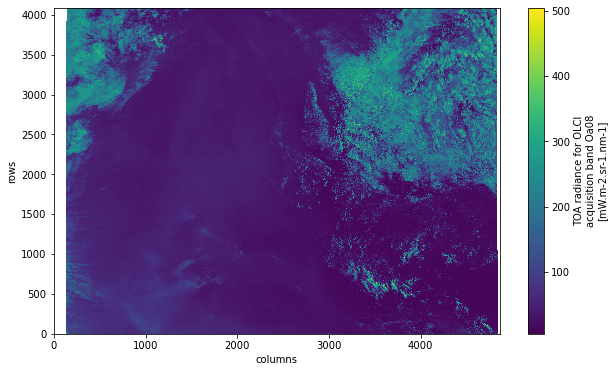

In [14]:
fig = plt.figure(figsize=(10,6))
olci_xr_mf['Oa08_radiance'].plot.imshow()

<br>

### <a id='load_geo_coords_s3'></a>Load OLCI geographic coordinates as `xarray`

If you want to georeference your image, you have to load the geographic coordinates file. You can load it as an xarray with the function `open_dataset`. The file is called `geo_coordinates.nc`. You see that the file contains three variables: `latitude`, `longitude` and `altitude`.

Let us store the latitude and longitude data as `lat` and `lon` variables respectively.

In [15]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')
olci_geo_coords

<xarray.Dataset>
Dimensions:    (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    altitude   (rows, columns) float32 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes:
    absolute_orbit_number:  17173
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2021-08-13T07:38:43Z
    history:                  2021-08-13T07:38:43Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3B_OL_1_EFR____20210812T031307_20210812T031607_2...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-12T03:13:07.277233Z
    stop_time:              2021-08-12T03:16:07.244935Z
    title:                  OLCI Level 1b Product, Geo Coordinates Data Set

<br>

In [16]:
lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

<br>

### <a id='channel_select_s3'></a>Select OLCI channels for a RGB image

Depending on the combination of different OLCI channels, your RGB image might highlight specific phenomena. The channel combination for a True Color RGB image could be:
- Red: `Oa08_radiance`
- Green: `Oa06_radiance`
- Blue: `Oa04_radiance`

You can use the function [select_channels_for_rgb](./functions.ipynb#rgb_channels), which allows to select three channels individually.

In [17]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 
                                           'Oa08_radiance', 
                                           'Oa06_radiance', 
                                           'Oa04_radiance')
red

<xarray.DataArray 'Oa08_radiance' (rows: 4091, columns: 4865)>
dask.array<open_dataset-6d91703478cdb9269d7ce44ff4357504Oa08_radiance, shape=(4091, 4865), dtype=float32, chunksize=(4091, 4865), chunktype=numpy.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    ancillary_variables:  Oa08_radiance_err
    coordinates:          time_stamp altitude latitude longitude
    long_name:            TOA radiance for OLCI acquisition band Oa08
    standard_name:        toa_upwelling_spectral_radiance
    units:                mW.m-2.sr-1.nm-1
    valid_max:            65534
    valid_min:            0

<br>

### <a id='image_processing_s3'></a>Advanced image processing - Normalization and histogram equalization

#### Normalization

A common operation in image processing is the normalization of data values. Normalization changes the range of pixel intensity and can improve the constrast. You can use the function [normalize](./functions.ipynb#normalize) to normalize each RGB channel. At the end, you can bring the three channels together into one `rgb` array with the function `numpy.dstack`. By verifying the shape of the resulting array, you see that the `rgb` array has now three dimensions.

In [18]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

In [19]:
rgb = np.dstack((redn, greenn, bluen))
rgb.shape

(4091, 4865, 3)

<br>

You can now plot the rgb image to see if maybe further image processing methods could be applied. If you visualize the image with `plt.imshow()`, you see that the constrast is not very strong. A further step is to sharpen the contrast with the help of a **Histogram equalization**.

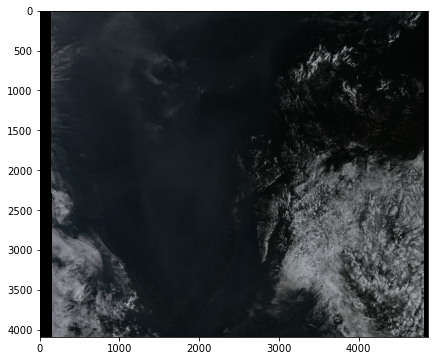

In [20]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

<br>

#### Histogram equalization

Histogram equalization is a method in image processing that adjusts the contrast using the image's histogram. Python's `skikit-learn` library has useful tools to make a histogram equalization easy. The `skimage` library provides a function `exposure.equalize_adaphtist()` which can be applied to the `rgb` data array.

In [21]:
rgb = exposure.equalize_adapthist(rgb)

<br>

You can again plot the rgb image with `plt.imshow()`. You can see that the histogram equalization improved the contrast of the image.

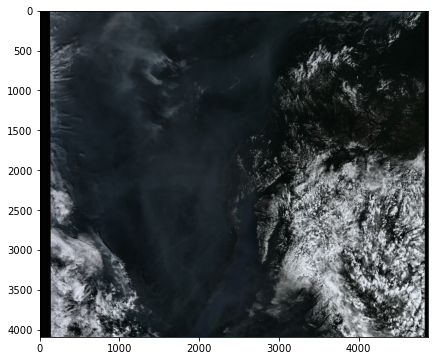

In [22]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

<br>

### <a id='visualize_tc_s3'></a>Visualize a georeferenced RGB True Color image with `pcolormesh`

The final step is to georeference the `RGB` image. Therefore, you need the `lat` and `lon` information extracted above.

Let us plot the image with matplotlib's `pcolormesh` function. To be able to visualize the array as RGB, you have to map first the rgb array to a colour array.

In [23]:
mesh_rgb = rgb[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

<br>

The last step is to visualize the color array and add additional information, e.g. gridlines and coastlines. You can use the function called [visualize_s3_pcolormesh](./functions.ipynb#visualize_s3_pcolormesh) to do so.

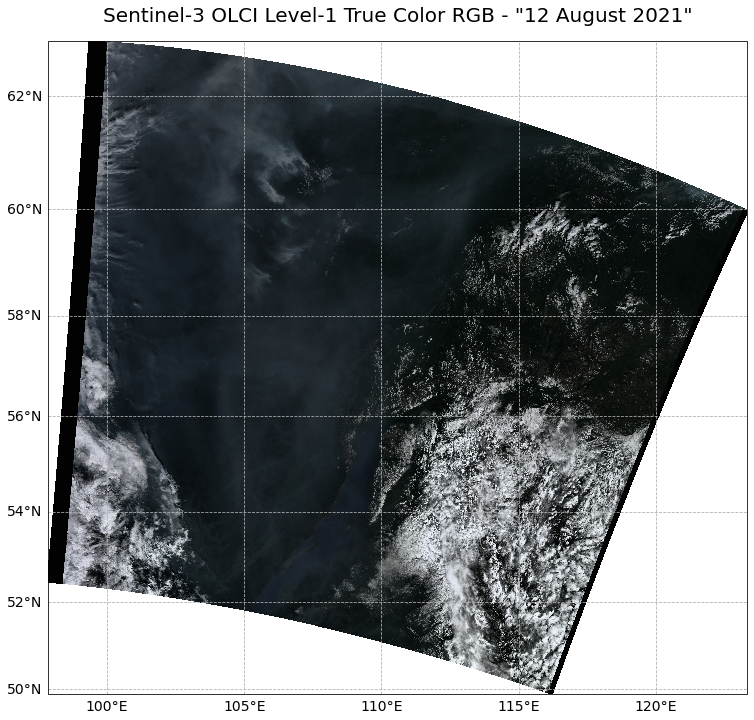

In [24]:
visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 True Color RGB - "12 August 2021"')

<br>

<br>

### <a id='false_color_s3'></a>Create a False Color RGB image and plot it as georeferenced image 

A false color RGB image can be applied if specific phenomena should be highlighted. A channel combination for Sentinel-3 OLCI data could be:
- Red: `Oa17_radiance`
- Green: `Oa05_radiance`
- Blue: `Oa02_radiance`

This selection is advantageous to identify burnt areas and wildfires. The combination highlights healthy vegeation as red and burnt areas as black.

Let's repeat the steps from above to visualize the image as False Color RGB composite.

#### Select RGB channels

The first step is to select the channels `Oa17_radiance`, `Oa05_radiance` and `Oa02_radiance` as red, green and blue channels respectively.

In [25]:
red_fc, green_fc, blue_fc = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')

<br>

#### Normalize

You also want to normalize these channels and stack them afterwards into a three-dimensional array.

In [26]:
redn_fc = normalize(red_fc)
greenn_fc = normalize(green_fc)
bluen_fc = normalize(blue_fc)

In [27]:
rgb_fc = np.dstack((redn_fc, greenn_fc, bluen_fc))

<br>

#### Histogram equalization

Apply histogram equalization.

In [28]:
rgb_fc = exposure.equalize_adapthist(rgb_fc)

<br>

Let us have a sneak-peak to the un-georefrenced image with `plt.imshow()`

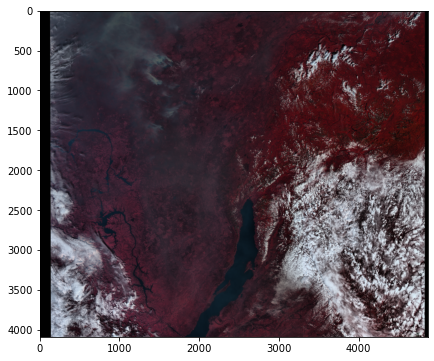

In [29]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb_fc)

<br>

#### Visualize with the function `visualize_s3_pcolormesh`

The last step is to visualize the false-color RGB with a geographic reference. First, you have to map the RGB values to a color array and then, you can use the function `visualize_s3_pcolormesh` to visualize the tile.

In [30]:
mesh_rgb = rgb_fc[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

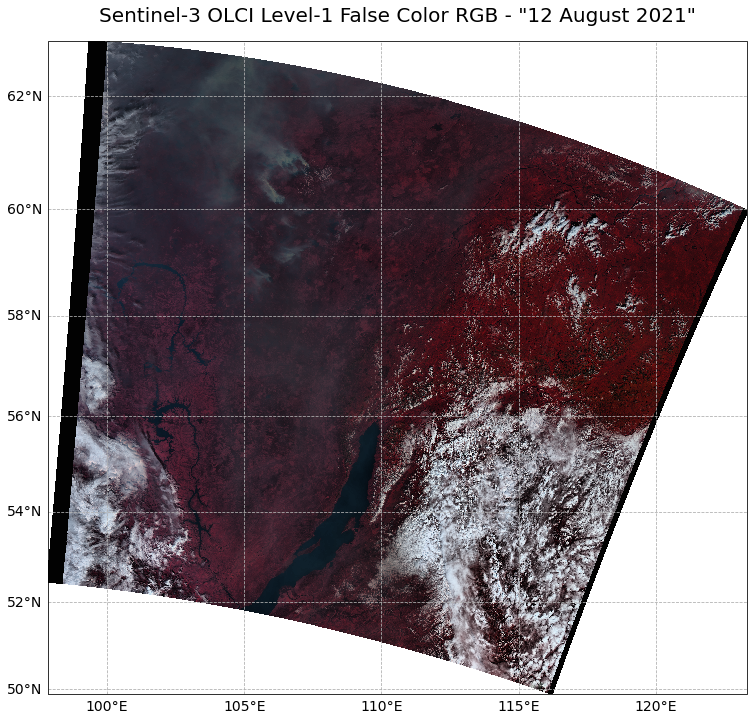

In [31]:
visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red, 
                        latitude=lat, 
                        longitude=lon,
                        title='Sentinel-3 OLCI Level-1 False Color RGB - "12 August 2021"',
                       )

<br>

<hr>

<br>

## <a id="aai"></a> AC SAF Metop-ABC GOME-2 Absorbing Aerosol Index

The Absorbing Aerosol Index (AAI) is an indicator of the presence of elevated absorbing aerosols in the Earth's atmosphere - such as soot particles in fire smoke which absorb and scatter incoming sunlight. The AAI data from 12 August 2021 show clearly the scale and extent of fires across Siberia.

<img src='../img/20210812_aai.png' alt='Absorbing Aerosol Index' align='centre' width='70%'></img>

<br>

Subsequently, we will show you how to handle the GOME-2 Level 3 Absorbing Aerosol Index data.<br>

The GOME-2 Level 3 AAI data files can be downloaded from the TEMIS website in `NetCDF` data format. TEMIS offers the data of all three satellites Metop-A, -B and -C, which, combined, provide daily measurements for the entire globe. For our case study, we will use data from Metop-A and -B, as data from Metop-C was not available in 2015.

The daily gridded data is available for each satellite. Thus, a first step is to inspect one file to get a better understanding of the general data structure. 

### Load and inspect the structure of a single gridded data file from Metop-A

The data is in the folder `/eodata/gome2/aai/`. Since the data is distributed in the `NetCDF` format, you can use the xarray function `open_dataset()` to load one single file to better understand the data structure.

In [5]:
file = './ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20210812-fv1.8.nc'
aai_gome2a = xr.open_dataset(file)
aai_gome2a

<xarray.Dataset>
Dimensions:                  (latitude: 180, longitude: 360)
Coordinates:
  * longitude                (longitude) float32 -179.5 -178.5 ... 178.5 179.5
  * latitude                 (latitude) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables:
    absorbing_aerosol_index  (latitude, longitude) float32 ...
    number_of_observations   (latitude, longitude) int16 ...
    solar_zenith_angle       (latitude, longitude) float32 ...
Attributes:
    Conventions:                CF-1.6
    title:                      ESA CCI absorbing aerosol index level 3 product
    description:                Multi-Sensor AAI field for 12-08-2021
    institution:                Royal Netherlands Meteorological Institute (K...
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-aerosol-cci.org
    product_version:            1.8
    cdm_data_type:              Grid
    date_created:               20210813T090539Z
    source:                     GOME-2A AAI version 1.35
    platform:                   METOP-A
    sensor:                     GOME-2
    history:                    2021-08-13 09:05:39 - Product generated using...
    tracking_id:                610f87b0-6ac8-11e6-bdf4-0800200c9a66
    keywords:                   satellite, atmosphere, aerosols, absorbing ae...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    naming_authority:           knmi.nl
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    creator_name:               Royal Netherlands Meteorological Institute (K...
    creator_url:                http://www.knmi.nl
    creator_email:              tilstra@knmi.nl
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lon_min:         -180.0
    geospatial_lon_max:         180.0
    geospatial_lat_resolution:  1.0
    geospatial_lon_resolution:  1.0
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    comment:                    Sun glint and solar eclipse events were filte...
    license:                    ESA CCI Data Policy: free and open access
    summary:                    This dataset contains absorbing aerosol index...

The output of the xarray `Dataset` above shows that one file contains the data of three variables: <br>
* `absorbing_aerosol_index`,
* `number_of_observations`, and
* `solar_zenith_angle`. 

The variable of interest is `absorbing aerosol_index`. By adding the variable of interest into square brackets `[]`, you can select the variable's `DataArray`. You can see that the daily gridded data are on a 1 deg x 1 deg data grid, with 180 latitude values and 360 longitude values.

In [6]:
aai_a = aai_gome2a['absorbing_aerosol_index']
aai_a


<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

Let's repeat the above steps for the AAI data from Metop-B.

In [11]:
file = './ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20210812-fv1.8.nc'
aai_gome2b = xr.open_dataset(file)
aai_gome2b

<xarray.Dataset>
Dimensions:                  (latitude: 180, longitude: 360)
Coordinates:
  * longitude                (longitude) float32 -179.5 -178.5 ... 178.5 179.5
  * latitude                 (latitude) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables:
    absorbing_aerosol_index  (latitude, longitude) float32 ...
    number_of_observations   (latitude, longitude) int16 ...
    solar_zenith_angle       (latitude, longitude) float32 ...
Attributes:
    Conventions:                CF-1.6
    title:                      ESA CCI absorbing aerosol index level 3 product
    description:                Multi-Sensor AAI field for 12-08-2021
    institution:                Royal Netherlands Meteorological Institute (K...
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-aerosol-cci.org
    product_version:            1.8
    cdm_data_type:              Grid
    date_created:               20210813T100519Z
    source:                     GOME-2B AAI version 1.35
    platform:                   METOP-B
    sensor:                     GOME-2
    history:                    2021-08-13 10:05:19 - Product generated using...
    tracking_id:                610f87b0-6ac8-11e6-bdf4-0800200c9a66
    keywords:                   satellite, atmosphere, aerosols, absorbing ae...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    naming_authority:           knmi.nl
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    creator_name:               Royal Netherlands Meteorological Institute (K...
    creator_url:                http://www.knmi.nl
    creator_email:              tilstra@knmi.nl
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lon_min:         -180.0
    geospatial_lon_max:         180.0
    geospatial_lat_resolution:  1.0
    geospatial_lon_resolution:  1.0
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    comment:                    Sun glint and solar eclipse events were filte...
    license:                    ESA CCI Data Policy: free and open access
    summary:                    This dataset contains absorbing aerosol index...

In [12]:
aai_b = aai_gome2b['absorbing_aerosol_index']
aai_b


<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-0.370541, -0.371094, -0.379229, ..., -0.388021, -0.388342, -0.381227],
       [-0.415066, -0.430058, -0.405528, ..., -0.43855 , -0.440324, -0.43429 ],
       [-0.418262, -0.385545, -0.410825, ..., -0.379155, -0.392646, -0.389337]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

Let's repeat the above steps for the AAI data from Metop-C.

In [13]:
file = './ESACCI-AEROSOL-L3-AAI-GOME2C-1D-20210812-fv1.8.nc'
aai_gome2c = xr.open_dataset(file)
aai_gome2c

<xarray.Dataset>
Dimensions:                  (latitude: 180, longitude: 360)
Coordinates:
  * longitude                (longitude) float32 -179.5 -178.5 ... 178.5 179.5
  * latitude                 (latitude) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables:
    absorbing_aerosol_index  (latitude, longitude) float32 ...
    number_of_observations   (latitude, longitude) int16 ...
    solar_zenith_angle       (latitude, longitude) float32 ...
Attributes:
    Conventions:                CF-1.6
    title:                      ESA CCI absorbing aerosol index level 3 product
    description:                Multi-Sensor AAI field for 12-08-2021
    institution:                Royal Netherlands Meteorological Institute (K...
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-aerosol-cci.org
    product_version:            1.8
    cdm_data_type:              Grid
    date_created:               20210813T110713Z
    source:                     GOME-2C AAI version 1.35
    platform:                   METOP-C
    sensor:                     GOME-2
    history:                    2021-08-13 11:07:13 - Product generated using...
    tracking_id:                610f87b0-6ac8-11e6-bdf4-0800200c9a66
    keywords:                   satellite, atmosphere, aerosols, absorbing ae...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    naming_authority:           knmi.nl
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    creator_name:               Royal Netherlands Meteorological Institute (K...
    creator_url:                http://www.knmi.nl
    creator_email:              tilstra@knmi.nl
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lon_min:         -180.0
    geospatial_lon_max:         180.0
    geospatial_lat_resolution:  1.0
    geospatial_lon_resolution:  1.0
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    comment:                    Sun glint and solar eclipse events were filte...
    license:                    ESA CCI Data Policy: free and open access
    summary:                    This dataset contains absorbing aerosol index...

In [14]:
aai_c = aai_gome2c['absorbing_aerosol_index']
aai_c


<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-0.127714, -0.141083, -0.148726, ..., -0.169669, -0.153791, -0.128036],
       [-0.242663, -0.241277, -0.208425, ..., -0.242437, -0.248455, -0.241949],
       [-0.186109, -0.154851, -0.212029, ..., -0.196792, -0.194117, -0.160715]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

## <a id='concat'></a>Concatenate the data from the three satellites Metop-A, -B and -C

The overall goal is to bring the AAI data from all three satellites together. Thus, the next step is to concatenate the `DataArrays` from the three satellites Metop-A, -B and -C and we call the dimension `satellite`. 
You can use the `concat()` function from the xarray library.

The result is a three-dimensional `DataArray`, with the dimensions `satellite`, `latitude` and `longitude`. You can see that the resulting `DataArray` holds coordinate information for the two spatial dimensions `longitude` and `latitude`, but not for `satellite`.

In [15]:
aai_concat = xr.concat([aai_a,aai_b, aai_c], dim='satellite')
aai_concat

<xarray.DataArray 'absorbing_aerosol_index' (satellite: 3, latitude: 180, longitude: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.37054113, -0.37109375, -0.3792295 , ..., -0.38802078,
         -0.3883424 , -0.38122678],
        [-0.41506633, -0.43005776, -0.4055277 , ..., -0.43855026,
         -0.44032437, -0.43428954],
        [-0.41826242, -0.3855448 , -0.4108255 , ..., -0.37915498,
         -0.39264563, -0.38933685]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.12771402, -0.14108314, -0.14872631, ..., -0.16966872,
         -0.1537914 , -0.1280362 ],
        [-0.24266298, -0.241277  , -0.20842499, ..., -0.24243732,
         -0.24845518, -0.24194944],
        [-0.1861089 , -0.15485092, -0.2120285 , ..., -0.19679175,
         -0.19411677, -0.16071533]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: satellite
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

<br>

## <a id='combine'></a>Combine AAI data from the three satellites Metop-A, -B and -C onto one single grid

Since the final aim is to combine the data from the three satellites Metop-A, -B and -C onto one single grid, the next step is to reduce the `satellite` dimension. You can do this by applying the reduced function `mean` to the `aai_concat` Data Array. The dimension (`dim`) to be reduced shall be the `satellite` dimension.

This function builds the average of all data points within a grid cell. The resulting `DataArray` has two dimensions `latitude` and `longitude`.

In [17]:
aai_combined = aai_concat.mean(dim='satellite')
aai_combined

<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.24912757, -0.25608844, -0.2639779 , ..., -0.27884474,
        -0.2710669 , -0.2546315 ],
       [-0.32886466, -0.33566737, -0.30697635, ..., -0.3404938 ,
        -0.34438977, -0.3381195 ],
       [-0.30218565, -0.27019787, -0.311427  , ..., -0.28797337,
        -0.2933812 , -0.27502608]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5

<br>

## <a id='visualize'></a>Visualize AAI data with data from the three satellites Metop-A, -B and -C combined on one single grid

The final step is to visualize the Absorbing Aerosol Index data. You can use the function `visualize_pcolormesh` for it.

You can use `afmhot_r` as color map, `ccrs.PlateCarree()` as projection and by using `str(aai_gome2a.description.split()[4])`, you can add the valid time step extracted from the file name of `aai_gome2a` to the title of the plot.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Absorbing aerosol index averaged for each grid cell 12-08-2021'}>)

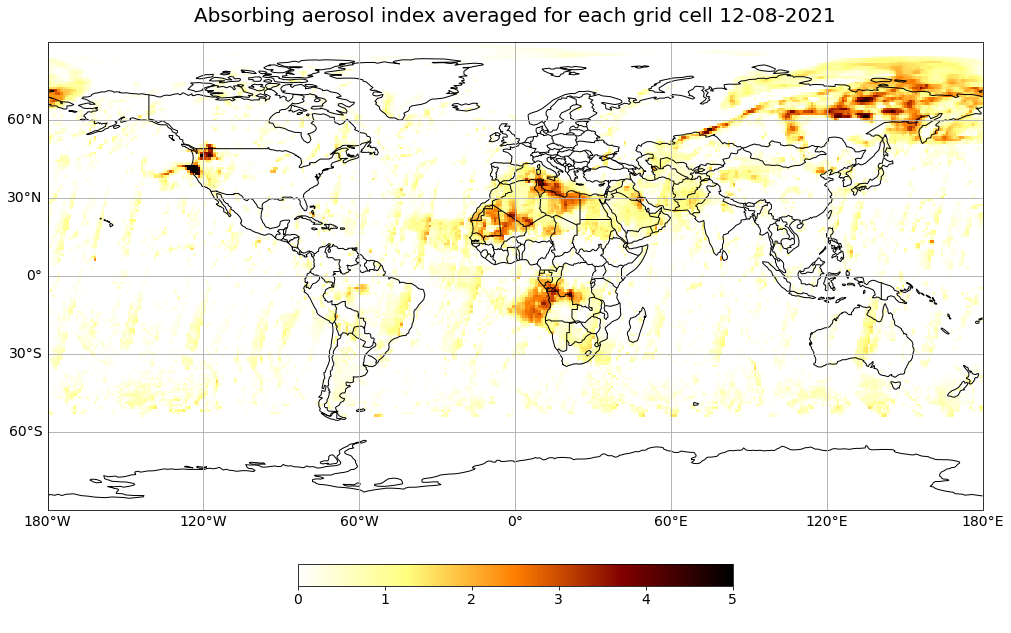

In [20]:
visualize_pcolormesh(data_array = aai_combined[:,:],
                     longitude = aai_combined.longitude, 
                     latitude = aai_combined.latitude,
                     projection = ccrs.PlateCarree(), 
                     color_scale = 'afmhot_r', 
                     unit = ' ',
                     long_name = aai_a.long_name + ' ' + str(aai_gome2a.description.split()[4]), 
                     vmin = 0, 
                     vmax = 5)


<br>

<br>

### You have arrived at the end of this workflow highlighting the devastating Siberian fires of 2021.

<br>

<img src='../img/20210812_s3_eum_siberia.png' alt='Siberian fires 2021, source: https://www.eumetsat.int/science-blog/siberian-smoke-plume-reaches-north-pole-fires-set-other-unwanted-records' align='centre' width='60%'></img>

<i>Caption: Composite image of the Siberian fires, taken on 12 August 2021 at 00:30 and 01:32 UTC from the Copernicus Sentinel-3’s Ocean and Land Colour Instrument (OLCI), showing the Dzhigda region and Sea of Okhotsk. </i>

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.